In [14]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import json
import torch

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

In [16]:
exp_name = "200910_uci_test"

In [25]:
def plot_grid(runs, y, yerr=None, ylabel="performance", x="weight_prior", ylim=None, title=None):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(10,10))

    for scale, axs in zip(scales, axes):
        for temp, ax in zip(temps, axs):
            df = runs.sort_values([x, "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
            df.plot(x=x, y=y, yerr=yerr, kind="bar", legend=False, ax=ax)
            ax.set_title(f"scale={scale} and T={temp}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)
    if title is not None:
        fig.suptitle(title)

    if title is not None:
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [18]:
runs = []
for config_file in glob(f"../results/{exp_name}/*/config.json"):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    runs.append(run_data)
runs_all = pd.concat(runs, axis=1).T

In [19]:
runs_all.head()

,batch_size,batchnorm,bias_loc,bias_prior,bias_prior_params,bias_scale,burnin,cycles,data,device,...,weight_prior,weight_prior_params,weight_scale,width,acc_mean,acc_std,acc_stderr,lp_mean,lp_std,lp_stderr
0,None,True,0,gaussian,{},1,100,1,UCI_naval,try_cuda,...,laplace_uniform,{},2.82,50,23578.9,0.965183,0.136497,-9.0937,0.000931412,2.69663e-05
1,None,True,0,gaussian,{},1,100,1,UCI_wine,try_cuda,...,gaussian_uniform,{},1.41,50,0.777738,0.0032053,0.000453299,-1.31619,0.899376,0.0711019
2,None,True,0,gaussian,{},1,100,1,UCI_wine,try_cuda,...,student-t_uniform,{},0.71,50,0.841504,0.004783,0.000676418,-1.33277,0.739919,0.0584958
3,None,True,0,gaussian,{},1,100,1,UCI_protein,try_cuda,...,student-t_uniform,{},2.82,50,NaN,NaN,NaN,NaN,NaN,NaN
4,None,True,0,gaussian,{},1,100,1,UCI_kin8nm,try_cuda,...,laplace_gamma,{},1.41,50,0.727384,0.00855674,0.00121011,-1.26005,0.76072,0.0265817


In [20]:
datasets = sorted(runs_all.data.unique())

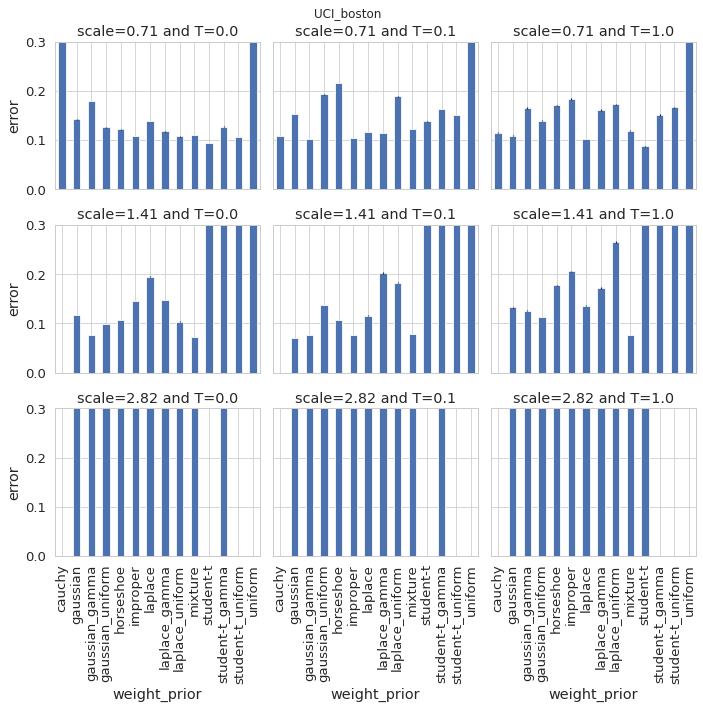

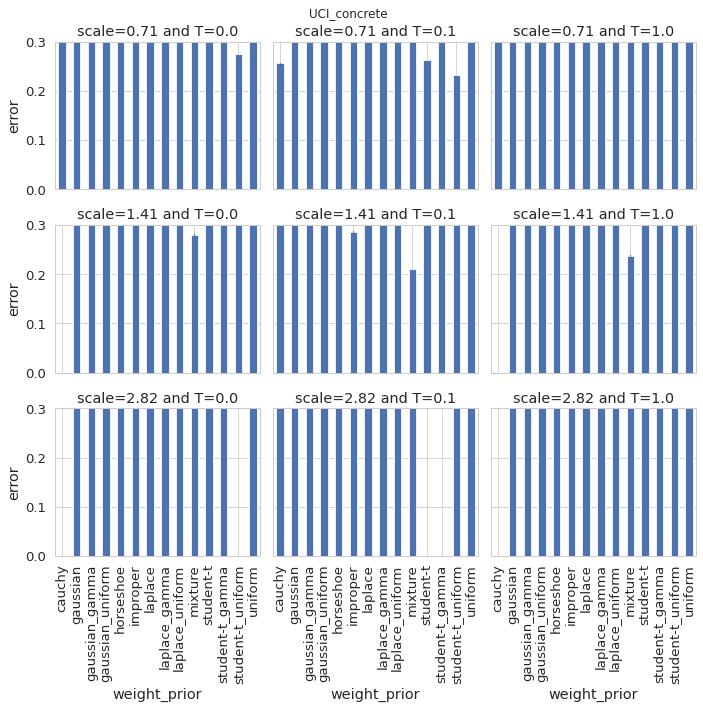

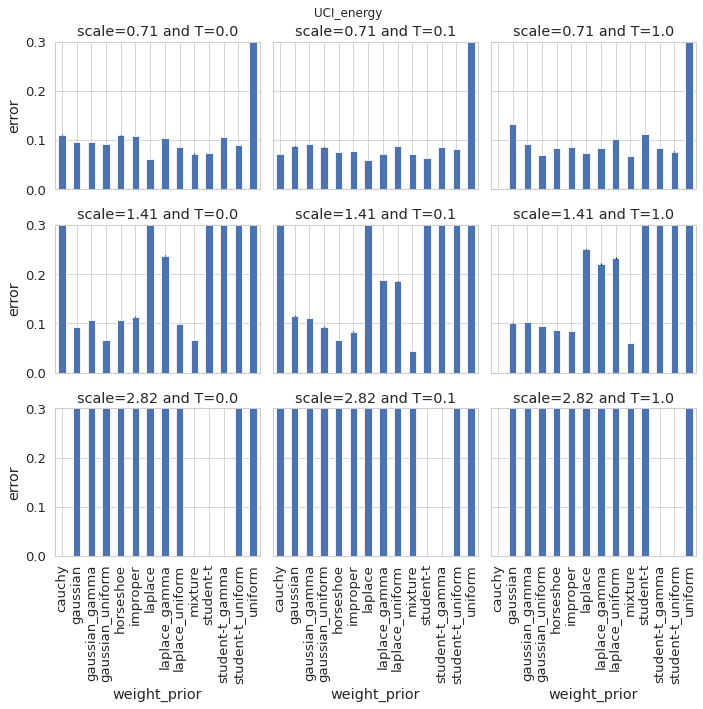

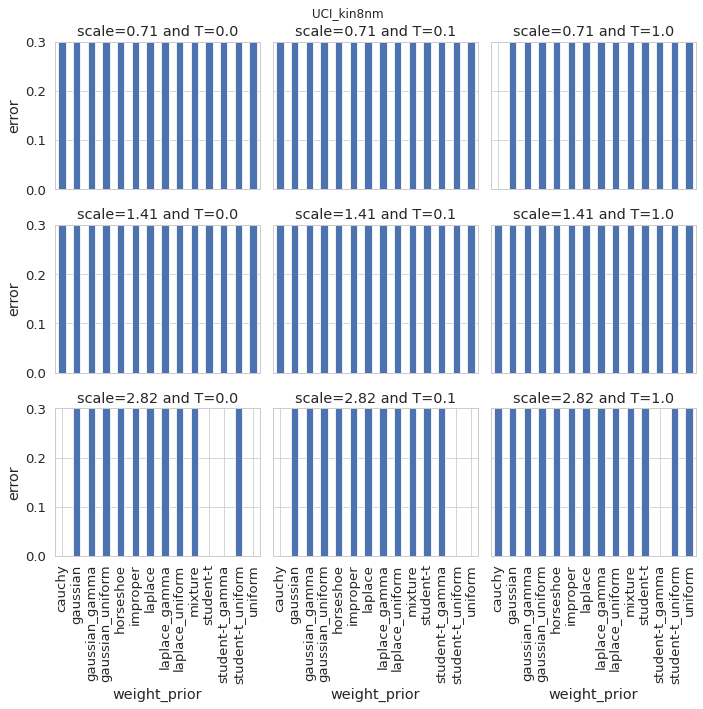

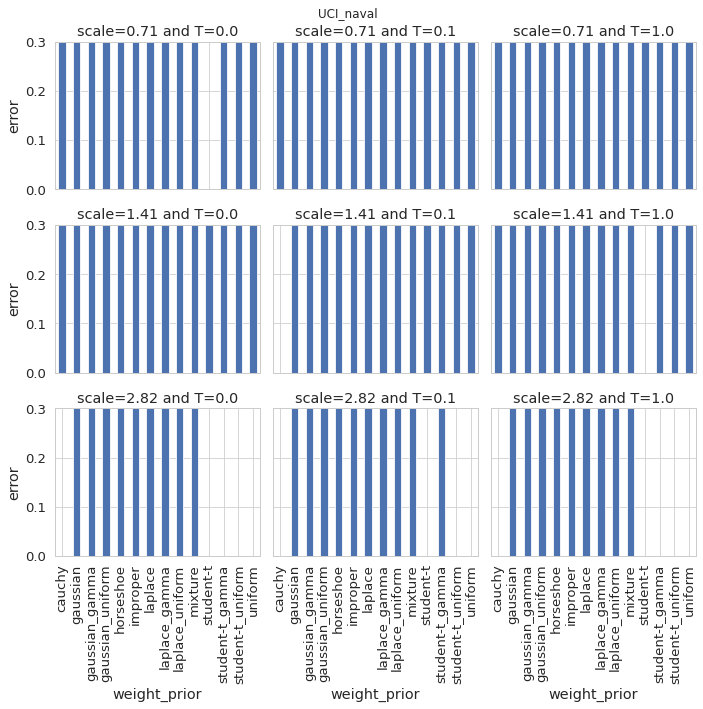

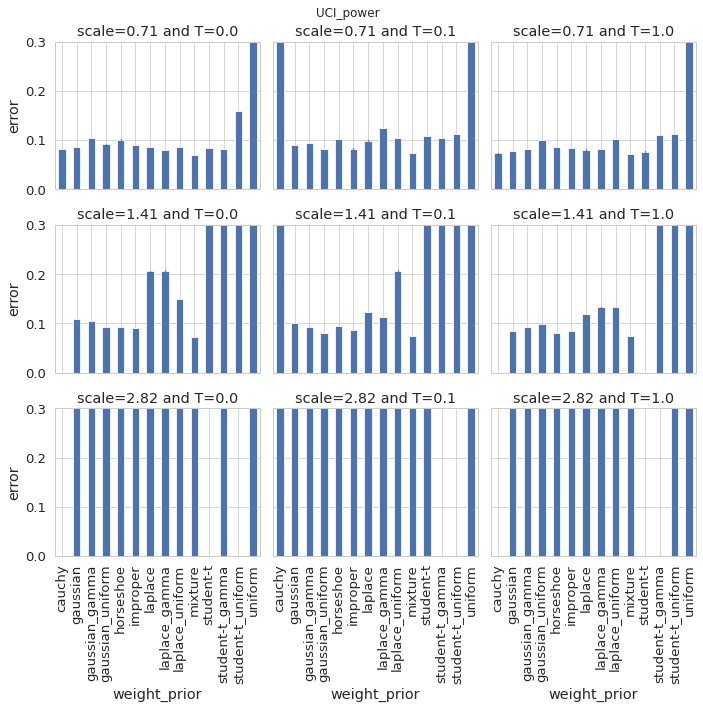

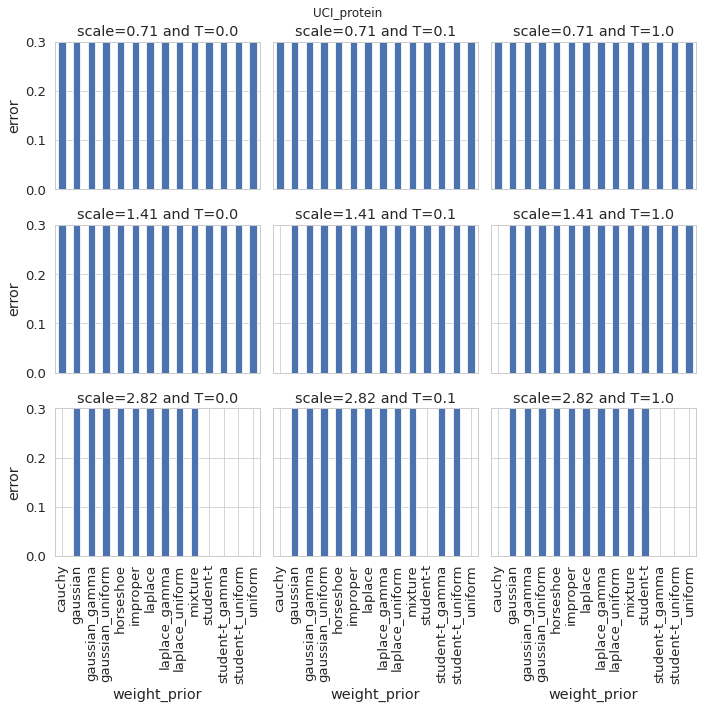

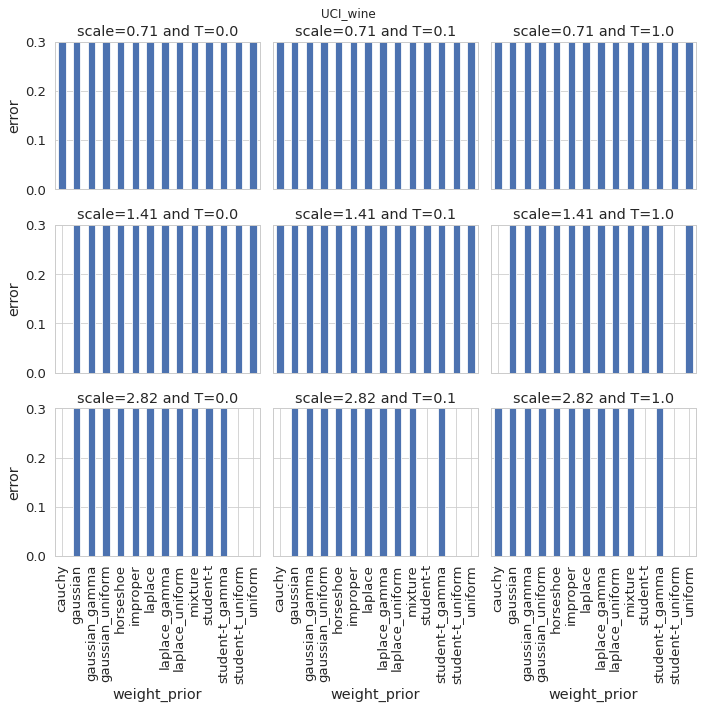

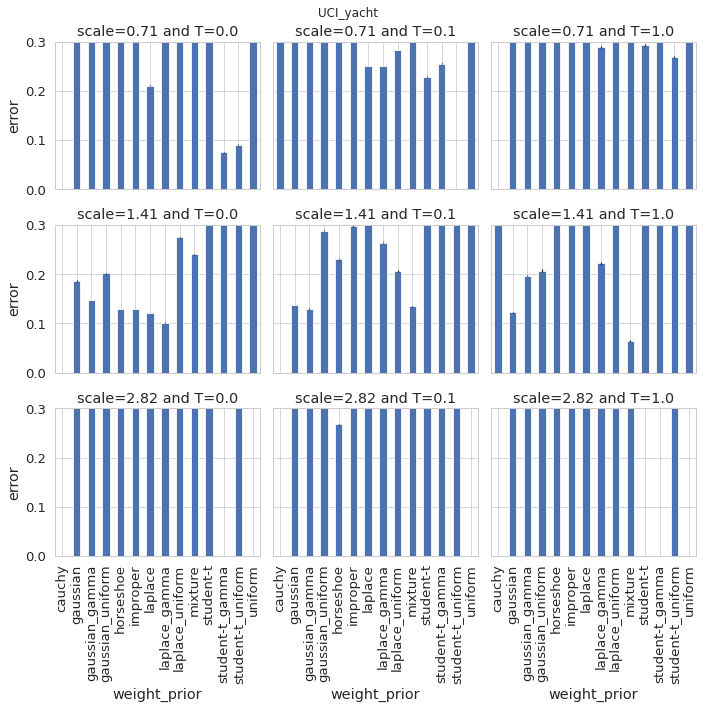

In [21]:
with PdfPages(f"../figures/{exp_name}_error.pdf") as pdf:
    for dataset in datasets:
        runs_selected = runs_all.query(f"data == '{dataset}'")
        fig = plot_grid(runs_selected, y="acc_mean", yerr="acc_stderr", ylabel="error", ylim=(0.,0.3), title=dataset)
        pdf.savefig()

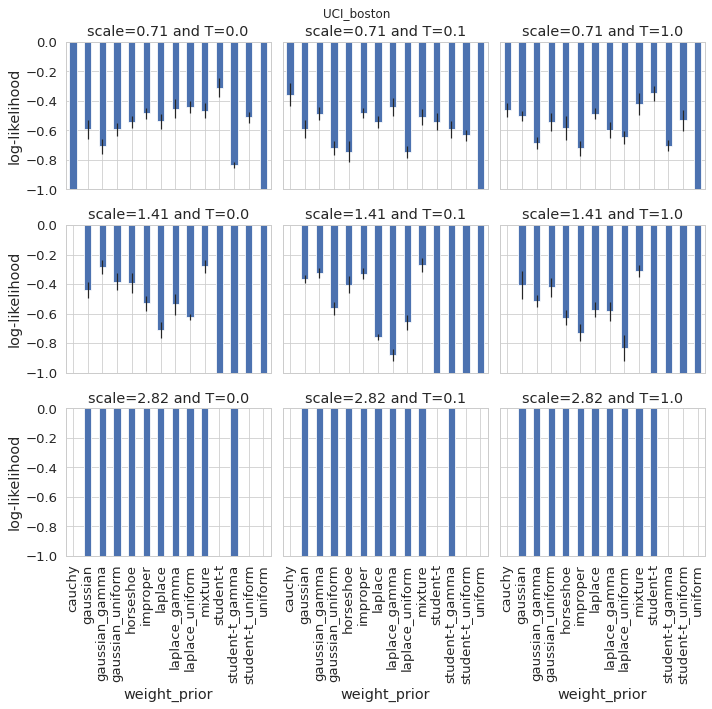

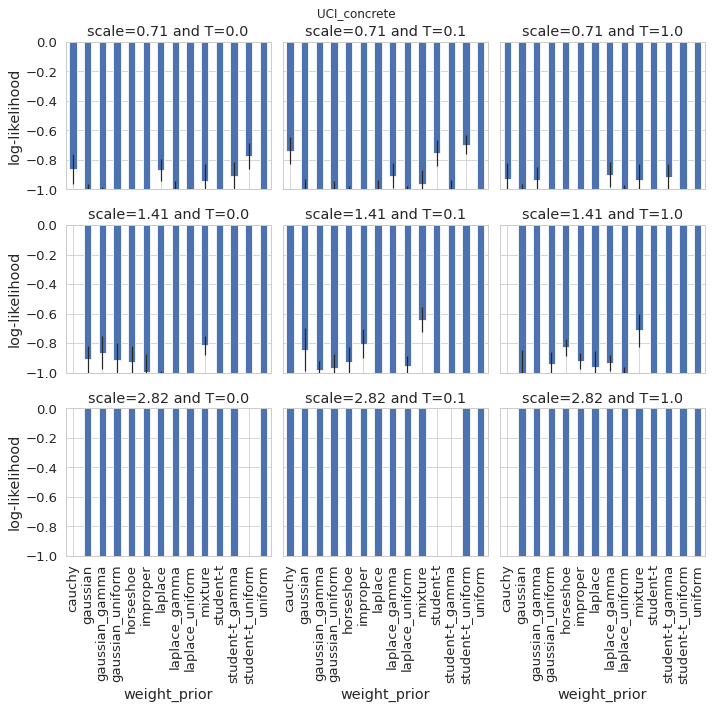

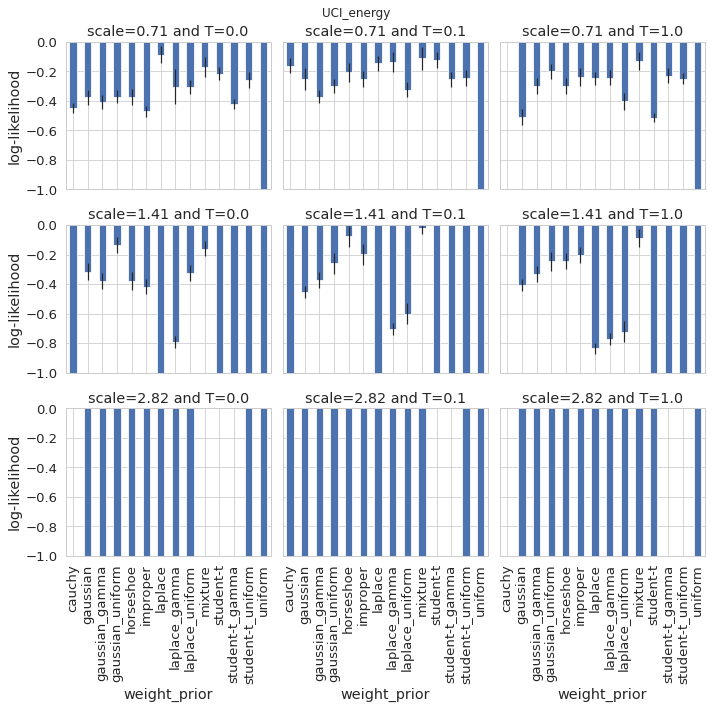

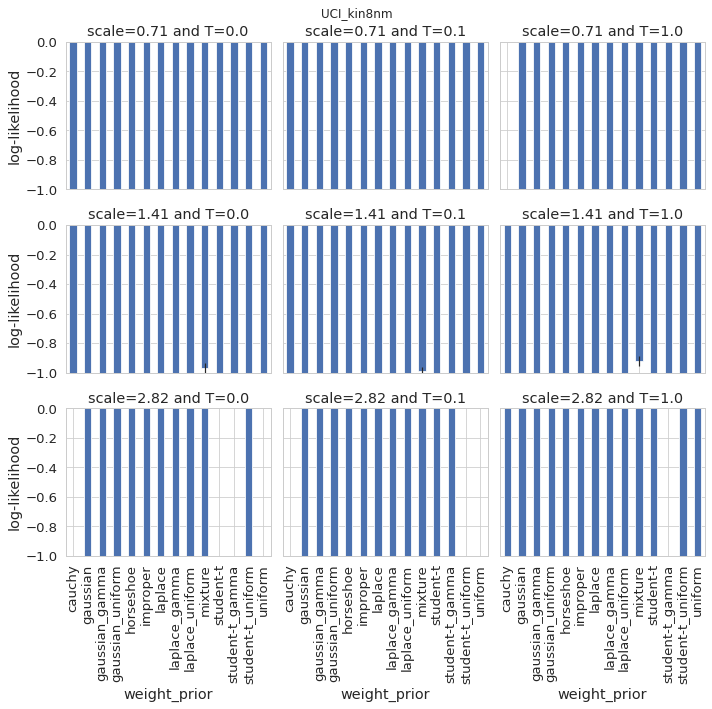

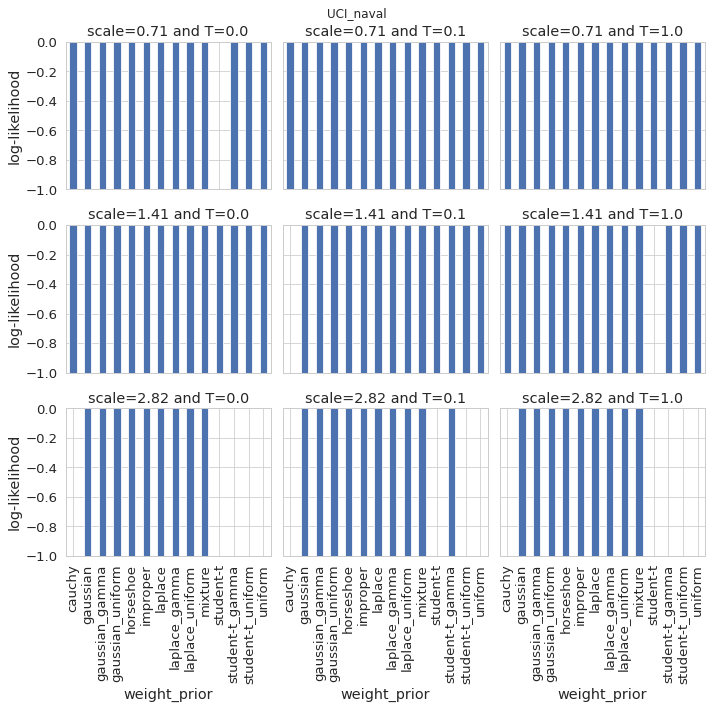

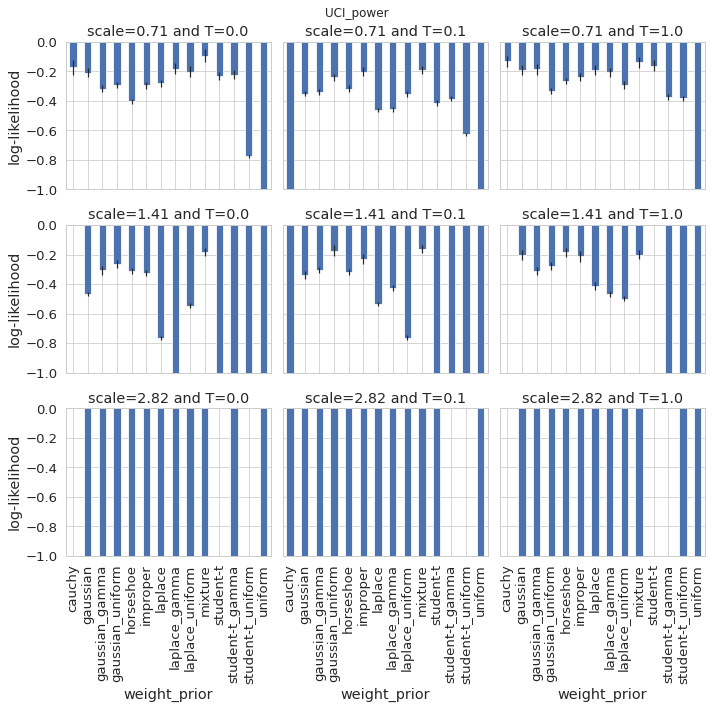

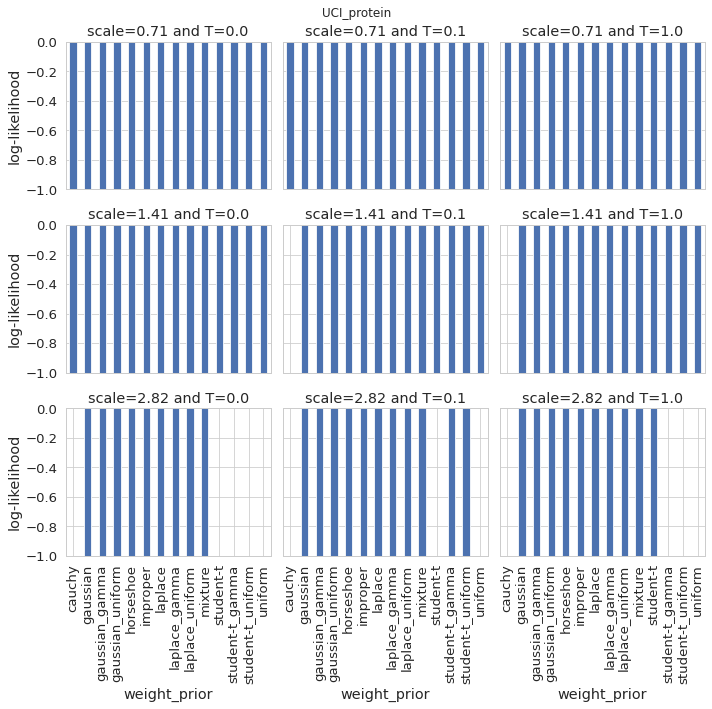

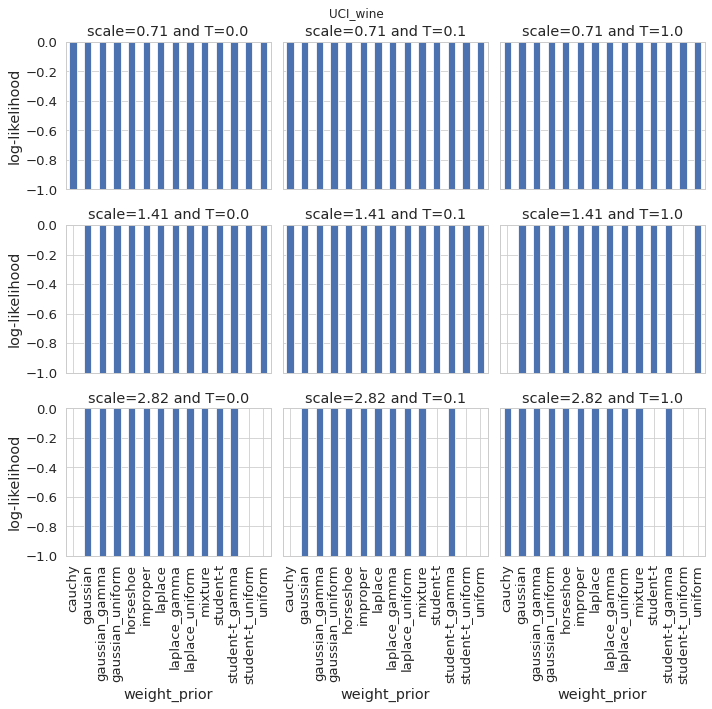

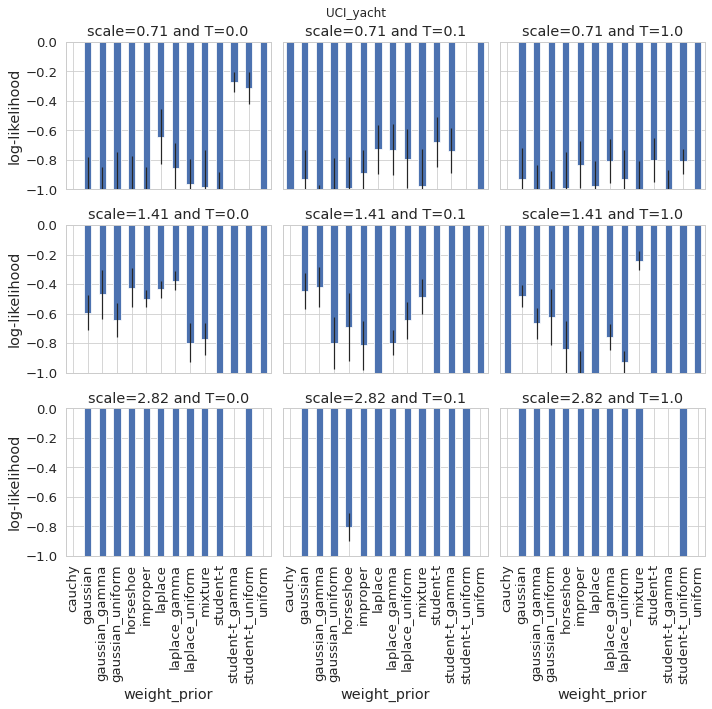

In [22]:
with PdfPages(f"../figures/{exp_name}_ll.pdf") as pdf:
    for dataset in datasets:
        runs_selected = runs_all.query(f"data == '{dataset}'")
        fig = plot_grid(runs_selected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-1., 0), title=dataset)
        pdf.savefig()

## Evaluate mixture models

In [30]:
components = ["gaussian", "laplace", "student-t", "cauchy"]

df_mixture = pd.DataFrame(columns=["data", "weight_scale", "temperature", "layer", "component", "weight", "log_weight"])

for config_file in glob(f"../results/{exp_name}/*/config.json"):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "mixture" and config["weight_prior_params"]=={}:
        samples = torch.load(os.path.join(os.path.dirname(config_file),"samples.pt"))
        mixture_weights = {k[:5]:torch.nn.functional.softmax(v[-1], dim=0).detach().numpy()
                   for k, v in samples.items() if "mixture_weights" in k}
        scale = config['weight_scale']
        temp = config['temperature']
        dataset = config['data']
        for layer, weights in mixture_weights.items():
            for comp, weight in zip(components, weights):
                df_mixture.loc[len(df_mixture)] = [dataset, scale, temp, layer, comp, weight, np.log(weight)]

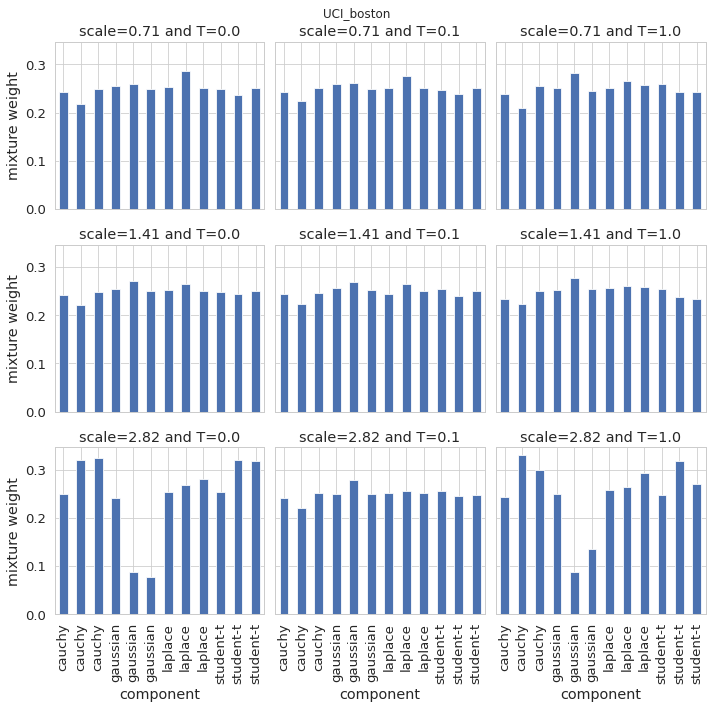

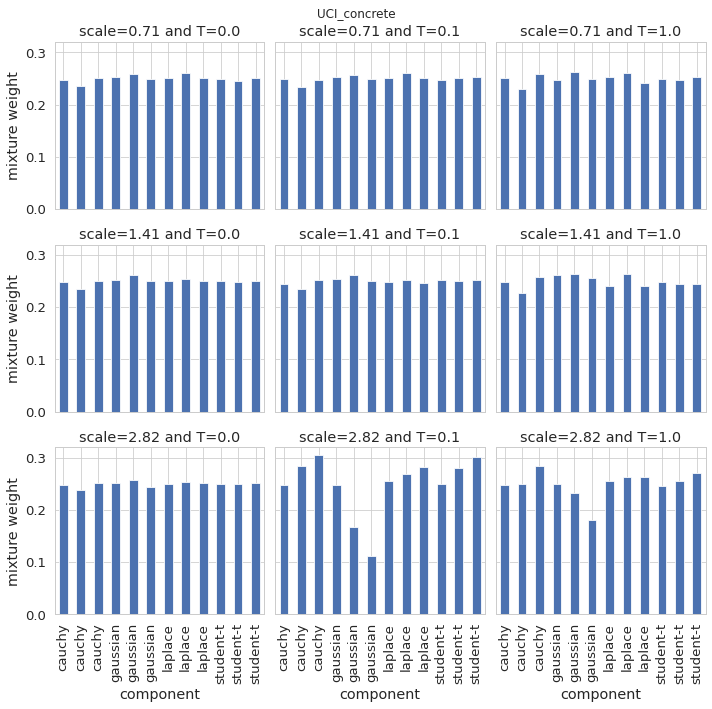

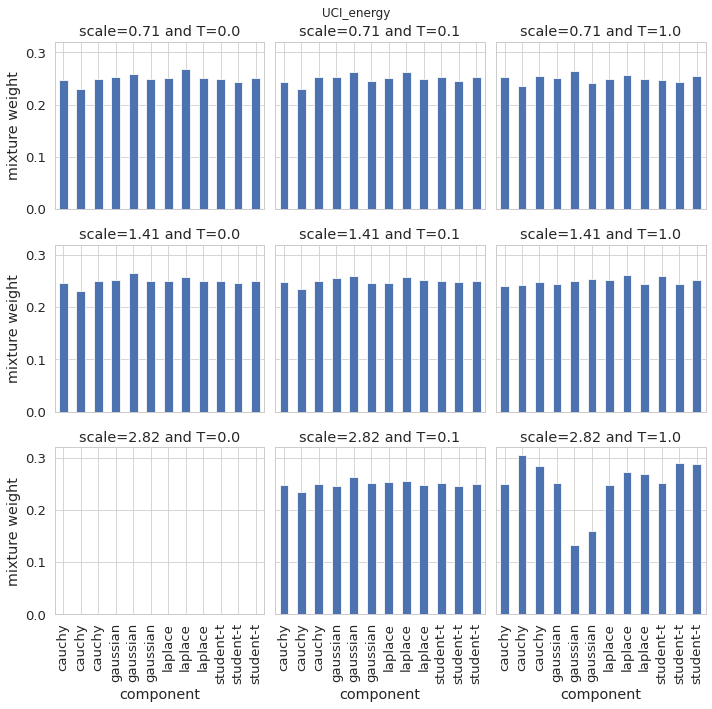

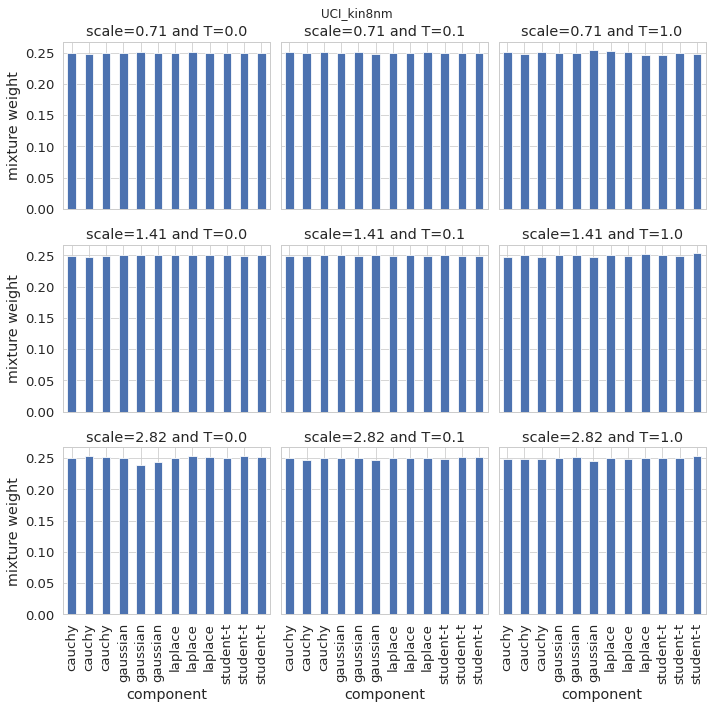

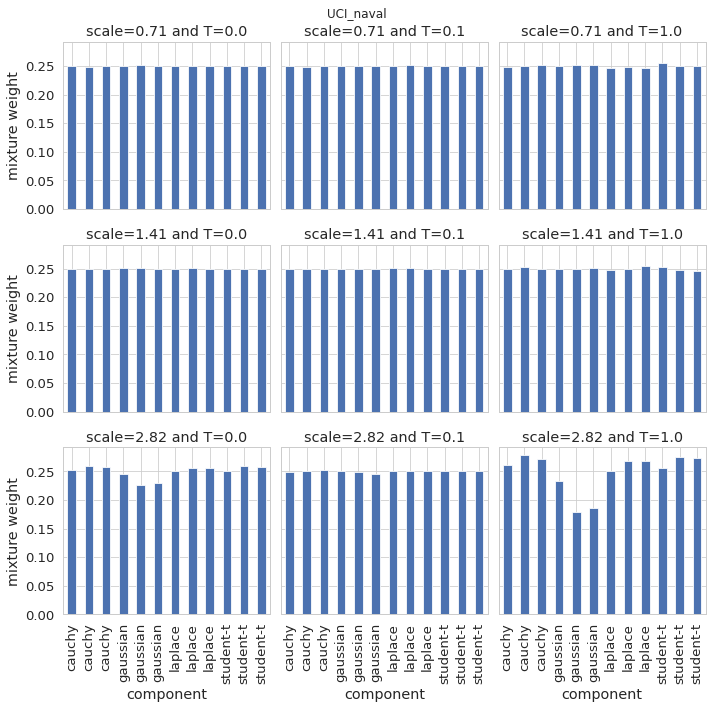

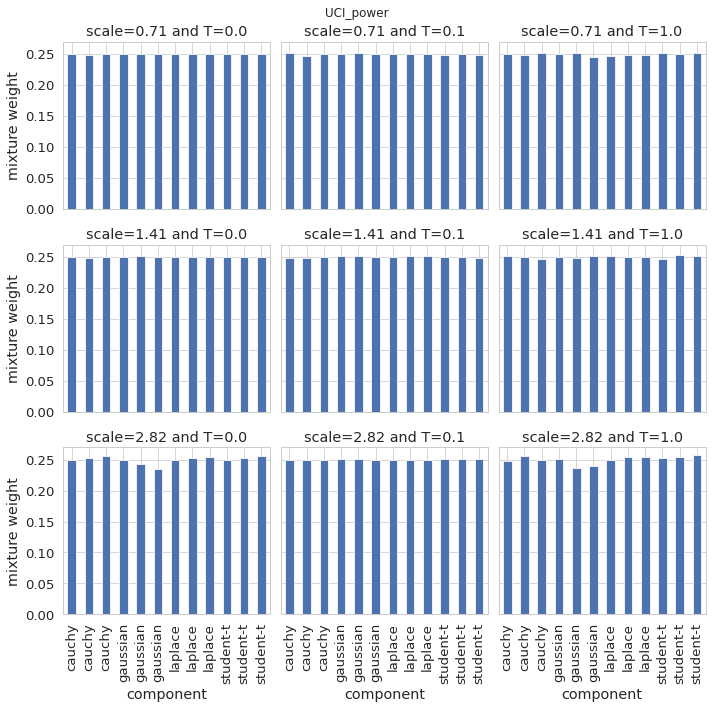

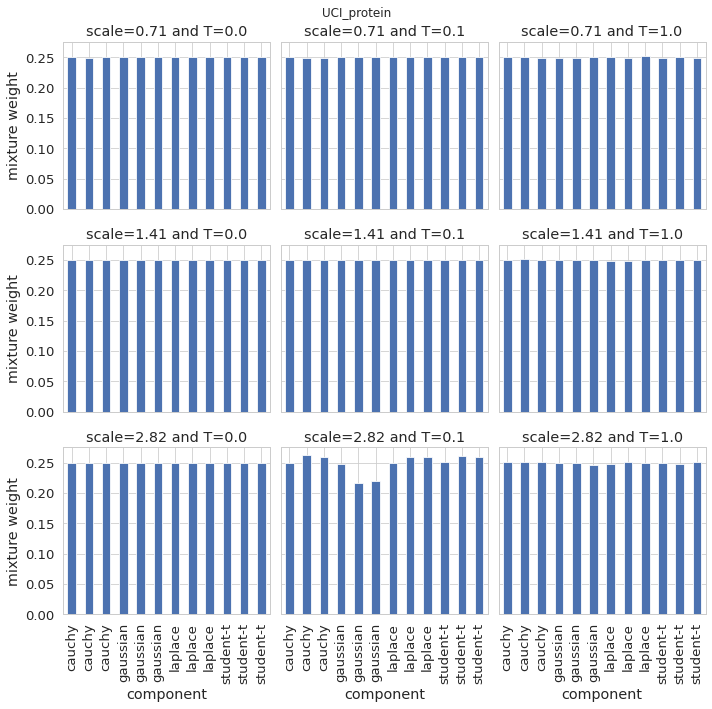

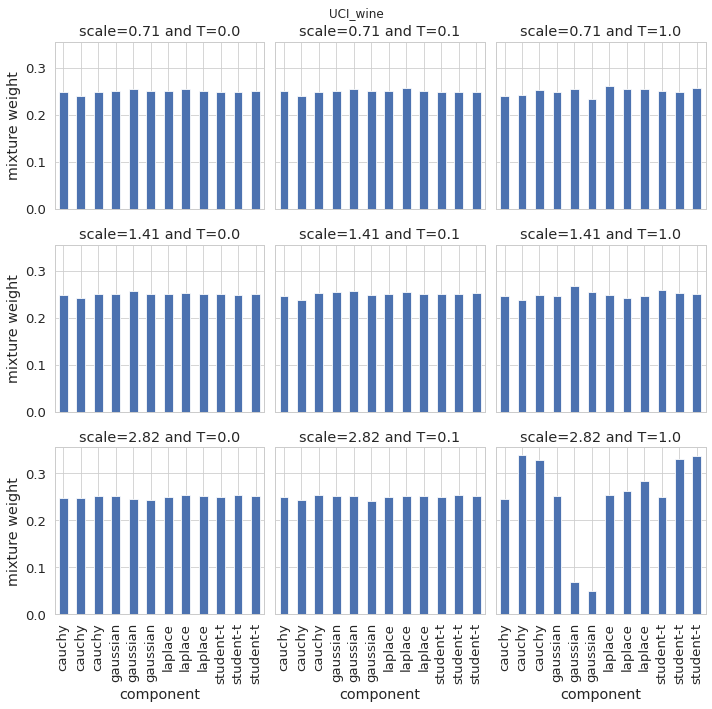

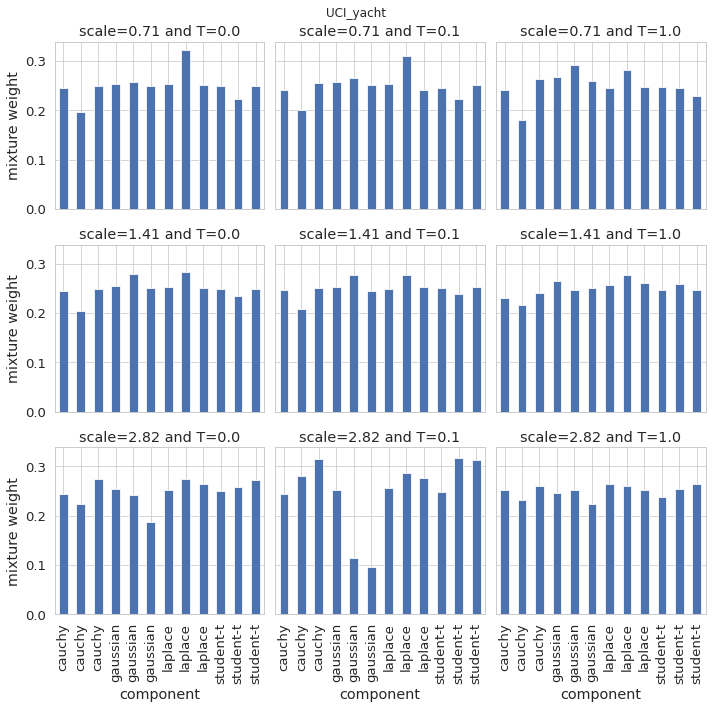

In [32]:
with PdfPages(f"../figures/{exp_name}_mixture_weights.pdf") as pdf:
    for dataset in datasets:
        runs_selected = df_mixture.query(f"data == '{dataset}'")
        fig = plot_grid(runs_selected, y="weight", ylabel="mixture weight", x="component", title=dataset)
        pdf.savefig()